In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
import rasterio

In [2]:
def pltshow(img):
    plt.imshow(img)
    plt.show()

In [3]:
# Load satellite image
satellite_path = "satellite.jpg"
img = cv2.imread(satellite_path)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [15]:
# Load LiDAR GeoTIFF
lidar_path = "lidar.tif"
with rasterio.open(lidar_path) as lidar:
    lidar_data = lidar.read(1)  # Read the first band (elevation)

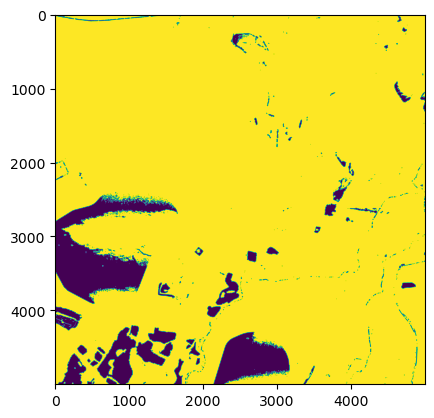

In [16]:
pltshow(lidar_data)

In [17]:
# # Avoid log(0) or negative values by shifting data
lidar_data_shifted = np.where(lidar_data <= 0, 1, lidar_data)

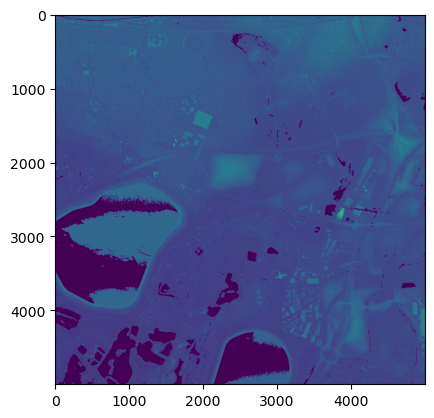

In [18]:
pltshow(lidar_data_shifted)

In [19]:
# Convert LIDAR data to log scale
log_lidar_data = np.log2(lidar_data_shifted)  

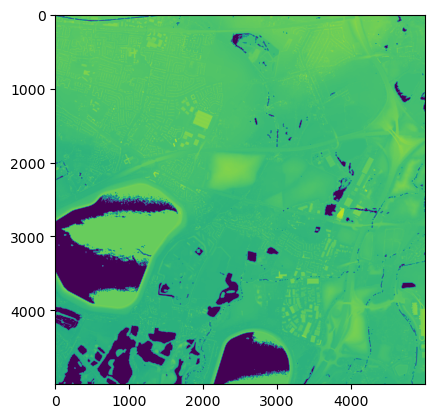

In [20]:
pltshow(log_lidar_data)

In [4]:
# Load EDSR model
sr = cv2.dnn_superres.DnnSuperResImpl_create()
model_path = "EDSR_x4.pb"
sr.readModel(model_path)
sr.setModel("edsr", 4)

In [5]:
# Super-resolve image (3-channel required)
result = sr.upsample(img_rgb)

# Convert result to uint8 format
first_result = np.clip(result, 0, 255).astype(np.uint8)

In [8]:
im.fromarray(first_result).save("EDSR_upscaled_4x_satellite.png")

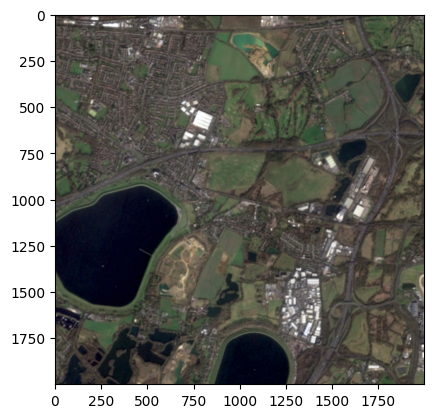

In [7]:
pltshow(first_result)

In [25]:
# Resize LiDAR to match satellite image dimensions
lidar_resized = cv2.resize(log_lidar_data, (first_result.shape[1], first_result.shape[0]))

# **Method 1: Use LiDAR as a Contrast Modifier (Multiply with RGB)**
# Convert LiDAR to float for processing
lidar_float = lidar_resized.astype(np.float32) / 255.0

# Enhance RGB with LiDAR (element-wise multiplication)
img_fused = (first_result.astype(np.float32) * (1 + lidar_float[:, :, np.newaxis])).clip(0, 255).astype(np.uint8)

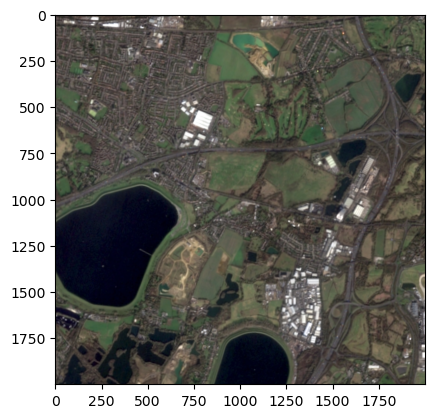

In [26]:
pltshow(img_fused)

In [27]:
# Super-resolve image (3-channel required)
result = sr.upsample(img_fused)

# Convert result to uint8 format
result_image = np.clip(result, 0, 255).astype(np.uint8)

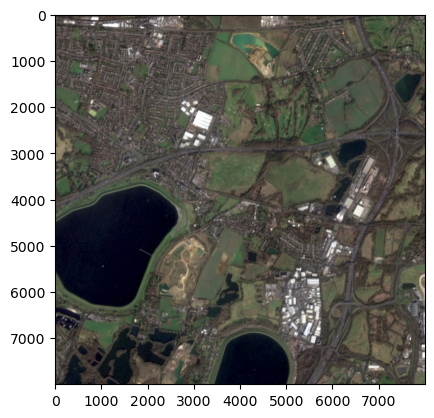

In [28]:
pltshow(result_image)

In [ ]:
# Save images
im.fromarray(result_image).save("EDSR_upscaled_log_2satellite.png")
im.fromarray(img_rgb).save("original_satellite.png")